# Entorno de pruebas sobre el modelo
## Bibliotecas

In [1]:
#RL libraries
from gym import Env
from gym.spaces import Discrete, Box
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

#Neural network libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

#Math libraries
import numpy as np
import random
import math

#Web server libraries
from werkzeug.wrappers import Request, Response
from werkzeug.serving import run_simple
from flask import Flask, render_template, request, redirect, url_for, flash
from wtforms import Form, FloatField, validators

#Visual libraries
import io
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import base64

## Entorno

In [2]:
class WindmillEnv(Env):
    def __init__(self, pRef):
        
        #Set action space
        self.action_space = Discrete(7)
        
        #Set observation space
        self.observation_space = Box(low=np.array([5]), high=np.array([14]))
        
        #Set training time
        self.training_length = 150
        
        #SET WINDMILL PARAMETERS
        #Static parameters
        self.wind_density = 1.225
        self.radious = 2
        self.wind = 10.0
        self.powerRef = pRef
        
        #Dynamic parameters
        self.angle = random.uniform(5.0, 14.0)
        self.power_eficiency = (-0.0422)*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
    
    
    def step(self, action):
        
        powerRefCheck = env.powerRef
        
        #Save the error from the previous step in a variable
        last_error = self.error
        
        #Reduces training time in 1 second
        self.training_length -= 1
        
        #Apply action
        if action == 0:
            self.angle += 0
        elif action == 1:
            self.angle += 0.001
        elif action == 2:
            self.angle -= 0.001
        elif action == 3:
            self.angle += 0.01
        elif action == 4:
            self.angle -= 0.01
        elif action == 5:
            self.angle += 1
        elif action == 6:
            self.angle -= 1
            
        for t in range(1, 151):
            self.power_eficiency = (-0.0422)*self.angle + 0.5911
            self.genPowerEuler += ((0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)
                                    *self.power_eficiency)/5 - self.genPowerEuler/5)*0.5
        
        if action == 1 or action == 2:
            action_value = 1
        elif action == 3 or action == 4:
            action_value = 2
        elif action == 5 or action == 6:
            action_value = 3
        else:
            action_value = 0
        
        #Calculates final error
        self.error = abs(powerRefCheck - self.genPowerEuler)
        
        #Calculates reward
        if self.error < last_error:
            reward = 1 - (self.error/10) + (action_value/100)
        if self.error > last_error:
            reward = -100 - (self.error/10) + (action_value/100)
        else:
            reward = -50 - (self.error/10) + (action_value/100)
            
        #Check if the training finished
        if self.training_length <= 0:
            done = True
        else:
            done = False
                
        #Placeholder for the info
        info = {}
        
        #Return step information
        return self.angle, reward, done, info
    
    
    #Reset parameters
    def reset(self):
        
        self.angle = random.uniform(5, 14)
        self.power_eficiency = (-0.0422)*self.angle + 0.5911
        self.genPowerEuler = 0.5*self.wind_density*math.pi*pow(self.radious, 2)*pow(self.wind, 3)*self.power_eficiency
        self.error = abs(self.powerRef - self.genPowerEuler)
        
        self.training_length = 150
        
        return self.angle
    
    
    #GETTERS AND SETTERS
    #Power Reference
    @property
    def powerRefMethod(self):
        return self.powerRef
    
    @powerRefMethod.setter
    def powerRefMethod(self, powerRefv):
        self.powerRef = powerRefv
    
    
    #Generated Power
    @property
    def genPowerEulerMethod(self):
        return self.genPowerEuler
    
    @genPowerEulerMethod.setter
    def genPowerEulerMethod(self, genPowerEulerv):
        self.genPowerEuler = genPowerEulerv
    
    
    #Angle
    @property
    def angleMethod(self):
        return self.angle
    
    @angleMethod.setter
    def angleMethod(self, anglev):
        self.angle = anglev
    
    
    #Training length
    @property
    def training_lengthMethod(self):
        return self.training_length
    
    @training_lengthMethod.setter
    def training_lengthMethod(self, training_lengthv):
        self.training_length = training_lengthv
        
    

In [3]:
env = WindmillEnv(1000)
states = env.observation_space.shape
actions = env.action_space.n

C:\Users\dgarr\anaconda3\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


## Red neuronal

In [4]:
def build_model(states, actions):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape = states))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [5]:
model = build_model(states, actions)

## Agente

In [6]:
def build_agent(model, actions):
    memory = SequentialMemory(limit=40000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=BoltzmannQPolicy(), nb_actions=actions, nb_steps_warmup=1000)
    return dqn

## Entrenamiento

In [7]:
dqn = build_agent(model, actions)
dqn.compile(Adam(learning_rate=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=30000, visualize=False, verbose=1)

Training for 30000 steps ...
Interval 1 (0 steps performed)
   92/10000 [..............................] - ETA: 12s - reward: -138.1151

C:\Users\dgarr\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 62s 6ms/step - reward: -199.6253
66 episodes - episode_reward: -30125.476 [-106123.099, -10931.199] - loss: 2206.767 - mae: 264.080 - mean_q: -268.880

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 69s 7ms/step - reward: -74.9500
67 episodes - episode_reward: -11256.271 [-19288.327, -9641.189] - loss: 299.848 - mae: 282.527 - mean_q: -272.566

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 70s 7ms/step - reward: -73.8881
done, took 200.301 seconds


## Pruebas

3 278.54856321577086 -77.83485632157709 1278.5485632157709 1000
3 275.3004705712244 -155.34490337869954 1275.3004705712244 1000
3 272.052377926678 -232.53014117136735 1272.052377926678 1000
3 268.8042852821318 -309.3905696995805 1268.8042852821318 1000
3 265.55619263758535 -385.92618896333903 1265.5561926375854 1000
3 262.3080999930387 -462.1369989626429 1262.3080999930387 1000
3 259.06000734849226 -538.0229996974922 1259.0600073484923 1000
3 255.81191470394606 -613.5841911678868 1255.811914703946 1000
3 252.56382205939963 -688.8205733738268 1252.5638220593996 1000
3 249.31572941485297 -763.7321463153121 1249.315729414853 1000
3 246.06763677030654 -838.3189099923427 1246.0676367703065 1000
3 242.81954412576033 -912.5808644049188 1242.8195441257603 1000
3 239.5714514812139 -986.5180095530402 1239.571451481214 1000
3 236.3233588366677 -1060.1303454367069 1236.3233588366677 1000
3 233.0752661921208 -1133.417872055919 1233.0752661921208 1000
3 229.8271735475746 -1206.3805894106763 1229.827

3 129.1363015666425 -10657.6299374485 1129.1363015666425 1000
3 125.88820892209628 -10720.19875834071 1125.8882089220963 1000
3 122.64011627754985 -10782.442769968466 1122.6401162775499 1000
3 119.39202363300319 -10844.361972331766 1119.3920236330032 1000
3 116.14393098845699 -10905.956365430611 1116.143930988457 1000
3 112.89583834391055 -10967.225949265003 1112.8958383439106 1000
3 109.64774569936435 -11028.170723834939 1109.6477456993644 1000
3 106.39965305481746 -11088.79068914042 1106.3996530548175 1000
3 103.15156041027126 -11149.085845181447 1103.1515604102713 1000
3 99.90346776572483 -11209.05619195802 1099.9034677657248 1000
3 96.65537512117862 -11268.701729470138 1096.6553751211786 1000
3 93.40728247663174 -11328.022457717801 1093.4072824766317 1000
3 90.15918983208553 -11387.01837670101 1090.1591898320855 1000
3 86.9110971875391 -11445.689486419764 1086.911097187539 1000
3 83.6630045429929 -11504.035786874063 1083.663004542993 1000
3 80.41491189844601 -11562.057278063907 108

3 249.3157294148807 -30093.116259020055 1249.3157294148807 1000
3 246.06763677033427 -30167.70302269709 1246.0676367703343 1000
3 242.81954412578807 -30241.964977109667 1242.819544125788 1000
3 239.57145148124164 -30315.90212225779 1239.5714514812416 1000
3 236.32335883669498 -30389.51445814146 1236.323358836695 1000
3 233.07526619214877 -30462.801984760674 1233.0752661921488 1000
3 229.82717354760234 -30535.764702115433 1229.8271735476023 1000
3 226.57908090305614 -30608.40261020574 1226.5790809030561 1000
3 223.33098825850925 -30680.715709031592 1223.3309882585093 1000
3 220.08289561396305 -30752.703998592988 1220.082895613963 1000
3 216.83480296941661 -30824.36747888993 1216.8348029694166 1000
3 213.5867103248704 -30895.70614992242 1213.5867103248704 1000
3 210.33861768032352 -30966.72001169045 1210.3386176803235 1000
3 207.09052503577732 -31037.409064194027 1207.0905250357773 1000
3 203.8424323912309 -31107.77330743315 1203.842432391231 1000
3 200.59433974668468 -31177.81274140782 

3 135.6324868557631 -39964.55362295069 1135.632486855763 1000
3 132.38439421121666 -40027.77206237181 1132.3843942112167 1000
3 129.13630156667045 -40090.66569252848 1129.1363015666705 1000
3 125.88820892212402 -40153.23451342069 1125.888208922124 1000
3 122.64011627757736 -40215.47852504845 1122.6401162775774 1000
3 119.39202363303093 -40277.39772741175 1119.392023633031 1000
3 116.14393098848473 -40338.9921205106 1116.1439309884847 1000
3 112.8958383439383 -40400.26170434499 1112.8958383439383 1000
3 109.64774569939163 -40461.20647891493 1109.6477456993916 1000
3 106.3996530548452 -40521.826444220416 1106.3996530548452 1000
3 103.151560410299 -40582.121600261446 1103.151560410299 1000
3 99.90346776575257 -40642.09194703802 1099.9034677657526 1000
3 96.6553751212059 -40701.73748455014 1096.655375121206 1000
3 93.40728247665947 -40761.058212797805 1093.4072824766595 1000
3 90.15918983211327 -40820.05413178101 1090.1591898321133 1000
3 86.91109718756684 -40878.72524149977 1086.911097187

3 62.50116446156153 -51579.607971058074 937.4988355384385 1000
3 65.74925710610796 -51686.162896768685 934.250742893892 1000
0 65.74925755074355 -51792.73782252376 934.2507424492564 1000
6 259.0599624402839 -51918.61381876779 1259.059962440284 1000
3 255.81191470398812 -51994.17501023819 1255.8119147039881 1000
3 252.56382205944806 -52069.41139244413 1252.563822059448 1000
3 249.31572941490163 -52144.322965385625 1249.3157294149016 1000
3 246.06763677035542 -52218.90972906266 1246.0676367703554 1000
3 242.81954412580853 -52293.17168347524 1242.8195441258085 1000
3 239.57145148126233 -52367.108828623364 1239.5714514812623 1000
3 236.3233588367159 -52440.721164507035 1236.323358836716 1000
3 233.0752661921697 -52514.008691126255 1233.0752661921697 1000
3 229.82717354762326 -52586.97140848102 1229.8271735476233 1000
3 226.5790809030766 -52659.609316571325 1226.5790809030766 1000
3 223.33098825853017 -52731.92241539718 1223.3309882585302 1000
3 220.08289561398396 -52803.91070495858 1220.08

3 67.42254132030916 -63309.054629244856 1067.4225413203092 1000
3 64.17444867576273 -63365.45207411243 1064.1744486757627 1000
3 60.92635603121607 -63421.52470971555 1060.926356031216 1000
3 57.67826338666964 -63477.27253605422 1057.6782633866696 1000
3 54.43017074212344 -63532.69555312843 1054.4301707421234 1000
3 51.182078097577005 -63587.79376093819 1051.182078097577 1000
3 47.9339854530308 -63642.56715948349 1047.9339854530308 1000
3 44.68589280848414 -63697.015748764345 1044.6858928084841 1000
3 41.43780016393771 -63751.13952878074 1041.4378001639377 1000
3 38.189707519391504 -63804.938499532676 1038.1897075193915 1000
3 34.94161487484507 -63858.412661020164 1034.941614874845 1000
3 31.693522230298413 -63911.562013243194 1031.6935222302984 1000
3 28.44542958575198 -63964.38655620177 1028.445429585752 1000
3 25.197336941205776 -64016.88628989589 1025.1973369412058 1000
3 21.949244296659344 -64069.06121432556 1021.9492442966593 1000
3 18.701151652112685 -64120.911329490766 1018.7011

3 56.004979172447975 -73590.16493141165 943.995020827552 1000
3 59.25307181699441 -73696.07023859335 940.7469281830056 1000
3 62.50116446154061 -73802.30035503951 937.4988355384594 1000
3 65.7492571060875 -73908.85528075011 934.2507428939125 1000
0 65.74925755072309 -74015.43020650519 934.2507424492769 1000
3 68.9973497506337 -74122.30994148026 931.0026502493663 1000
3 72.24544239518013 -74229.51448571977 927.7545576048199 1000
3 75.49353503972634 -74337.04383922374 924.5064649602737 1000
6 249.31568450666555 -74461.9454076744 1249.3156845066655 1000
3 246.06763677036975 -74536.53217135144 1246.0676367703697 1000
3 242.81954412582945 -74610.79412576402 1242.8195441258295 1000
3 239.57145148128325 -74684.73127091215 1239.5714514812832 1000
3 236.32335883673682 -74758.34360679582 1236.3233588367368 1000
3 233.07526619219016 -74831.63113341504 1233.0752661921902 1000
3 229.82717354764372 -74904.5938507698 1229.8271735476437 1000
3 226.57908090309752 -74977.23175886011 1226.5790809030975 1

3 125.8882089221654 -84493.01878342193 1125.8882089221654 1000
3 122.6401162776192 -84555.26279504968 1122.6401162776192 1000
3 119.39202363307231 -84617.18199741299 1119.3920236330723 1000
3 116.14393098852611 -84678.77639051185 1116.143930988526 1000
3 112.89583834397968 -84740.04597434624 1112.8958383439797 1000
3 109.64774569943347 -84800.99074891619 1109.6477456994335 1000
3 106.39965305488681 -84861.61071422168 1106.3996530548868 1000
3 103.15156041034038 -84921.90587026271 1103.1515604103404 1000
3 99.90346776579418 -84981.87621703929 1099.9034677657942 1000
3 96.65537512124774 -85041.52175455142 1096.6553751212477 1000
3 93.40728247670108 -85100.84248279908 1093.407282476701 1000
3 90.15918983215465 -85159.8384017823 1090.1591898321547 1000
3 86.91109718760845 -85218.50951150106 1086.9110971876084 1000
3 83.66300454306202 -85276.85581195536 1083.663004543062 1000
3 80.41491189851536 -85334.87730314521 1080.4149118985154 1000
3 77.16681925396892 -85392.57398507062 1077.166819253

3 148.62485743401112 -106016.09440120023 1148.6248574340111 1000
3 145.3767647894647 -106080.61207767918 1145.3767647894647 1000
3 142.12867214491848 -106144.80494489367 1142.1286721449185 1000
3 138.8805795003716 -106208.6730028437 1138.8805795003716 1000
3 135.6324868558254 -106272.21625152929 1135.6324868558254 1000
3 132.38439421127896 -106335.43469095041 1132.384394211279 1000
3 129.13630156673275 -106398.32832110708 1129.1363015667328 1000
3 125.8882089221861 -106460.8971419993 1125.888208922186 1000
3 122.64011627763966 -106523.14115362706 1122.6401162776397 1000
3 119.39202363309346 -106585.06035599037 1119.3920236330935 1000
3 116.14393098854703 -106646.65474908923 1116.143930988547 1000
3 112.89583834400037 -106707.92433292362 1112.8958383440004 1000
3 109.64774569945394 -106768.86910749356 1109.647745699454 1000
3 106.39965305490773 -106829.48907279906 1106.3996530549077 1000
3 103.1515604103613 -106889.78422884009 1103.1515604103613 1000
3 99.9034677658151 -106949.754575616

3 4.035496859663681 -116024.82432106807 995.9645031403363 1000
3 7.283589504210113 -116125.53268001848 992.7164104957899 1000
3 10.531682148756317 -116226.56584823337 989.4683178512437 1000
3 13.779774793302977 -116327.9238257127 986.220225206697 1000
3 17.02786743784941 -116429.60661245648 982.9721325621506 1000
3 20.27596008239584 -116531.61420846473 979.7240399176042 1000
3 23.524052726942045 -116633.94661373743 976.475947273058 1000
3 26.772145371488477 -116736.60382827457 973.2278546285115 1000
3 30.020238016035137 -116839.58585207617 969.9797619839649 1000
3 33.26833066058157 -116942.89268514223 966.7316693394184 1000
3 36.51642330512777 -117046.52432747274 963.4835766948722 1000
3 39.764515949674205 -117150.4807790677 960.2354840503258 1000
3 43.012608594220865 -117254.76203992713 956.9873914057791 1000
3 46.2607012387673 -117359.368110051 953.7392987612327 1000
3 49.5087938833135 -117464.29898943932 950.4912061166865 1000
3 52.75688652785993 -117569.55467809211 947.243113472140

3 187.60196916858877 -126894.4866623224 1187.6019691685888 1000
3 184.35387652404233 -126962.9020499748 1184.3538765240423 1000
3 181.10578387949613 -127030.99262836274 1181.1057838794961 1000
3 177.8576912349497 -127098.75839748624 1177.8576912349497 1000
3 174.6095985904035 -127166.19935734528 1174.6095985904035 1000
3 171.3615059458566 -127233.31550793987 1171.3615059458566 1000
3 168.1134133013104 -127300.10684927 1168.1134133013104 1000
3 164.86532065676397 -127366.57338133568 1164.865320656764 1000
3 161.61722801221777 -127432.7151041369 1161.6172280122178 1000
3 158.36913536767088 -127498.53201767367 1158.3691353676709 1000
3 155.12104272312467 -127564.02412194599 1155.1210427231247 1000
3 151.87295007857824 -127629.19141695385 1151.8729500785782 1000
3 148.62485743403204 -127694.03390269725 1148.624857434032 1000
3 145.37676478948515 -127758.5515791762 1145.3767647894852 1000
3 142.12867214493895 -127822.7444463907 1142.128672144939 1000
3 138.8805795003925 -127886.61250434074 

3 57.67826338673899 -136932.0400962681 1057.678263386739 1000
3 54.43017074219256 -136987.4631133423 1054.4301707421926 1000
3 51.182078097646354 -137042.56132115205 1051.1820780976464 1000
3 47.93398545309992 -137097.33471969736 1047.9339854531 1000
3 44.68589280855326 -137151.78330897822 1044.6858928085533 1000
3 41.43780016400683 -137205.90708899463 1041.4378001640068 1000
3 38.189707519460626 -137259.7060597466 1038.1897075194606 1000
3 34.941614874914194 -137313.18022123407 1034.9416148749142 1000
3 31.693522230367535 -137366.3295734571 1031.6935222303675 1000
3 28.44542958582133 -137419.15411641568 1028.4454295858213 1000
3 25.197336941274898 -137471.6538501098 1025.197336941275 1000
3 21.949244296728466 -137523.8287745395 1021.9492442967285 1000
3 18.701151652181807 -137575.67888970472 1018.7011516521818 1000
3 15.453059007635375 -137627.20419560547 1015.4530590076354 1000
3 12.20496636308917 -137678.40469224178 1012.2049663630892 1000
3 8.956873718542738 -137729.28037961363 100

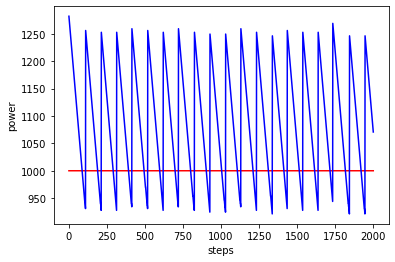

In [14]:
episodes = 1
powerArray = []
anglesArray = []
powerRefArray = []

for episode in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    env.training_lengthMethod = 2000
    initTrainingLenght = env.training_lengthMethod
    
    powerArray.append(env.genPowerEuler)
    anglesArray.append(env.angleMethod)
    powerRefArray.append(env.powerRefMethod)
    
    env.powerRefMethod = 1000
    
    while not done:
        action = dqn.forward(obs)
        obs, reward, done, info = env.step(action)
        score += reward
        
        print(action, env.error, score, env.genPowerEulerMethod, env.powerRefMethod)
            
        powerArray.append(env.genPowerEuler)
        anglesArray.append(env.angleMethod)
        powerRefArray.append(env.powerRefMethod)
        
    print('Episode:{} Score:{} Steps:{} Final Power:{}'.format(episode, score, initTrainingLenght - env.training_lengthMethod, env.genPowerEuler))
    
plt.xlabel("steps")
plt.ylabel("power")
plt.plot(powerRefArray, 'r')
plt.plot(powerArray, 'b')
plt.show()